# Ensemble Learning and Random Forests

*wisdom of the crowd* - an answer to a complex question, aggregated over thousands of random people, in many cases is better than an expert's answer

This is the core idea behind *ensemble learning*. In this method of prediction, we aggregate the predictions of a group of predictors (like classifiers or regressors). The group of predictors is called an *ensemble*.

Consider a single Decision Tree Classifier. If we train a group of singular Decision Trees, each on a random subset of a larger training set, we are performing ensemble learning. To make a prediction then, we would ask each Decision Tree to make a prediction, then return the class that gets the most votes among all the Decision Trees. This ensemble of Decision Trees is called a *Random Forest*.

Popular ensemble methods include: *bagging*, *boosting*, and *stacking*.

## Voting Classifiers

### Hard Voting 

Suppose you have a group of trained classifers. For example, a KNN, SVM, Random Forest, and Logistic Regression classifier, each with an accuracy of 80%. A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes! This majority-vote classifier is called a *hard voting* classifier.

A hard voting classifier will often perform better than the individual classifiers from which it is made. Even if each classifier is a *weak learner* (meaning it does only slightly better than randomly guessing), the ensemble can still be a *strong learner*, provided there are a sufficient number of weak learners and they are sufficiently diverse.

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the change that they will make very different types of errors, improving the ensemble's accuracy.

Let's train a voting classifier using the moons dataset from Ch. 5 of the textbook:

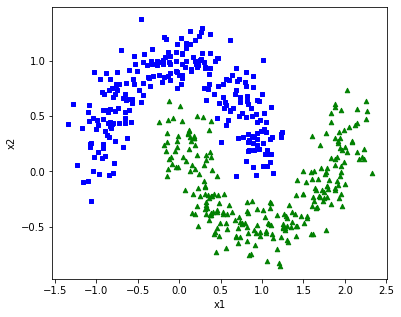

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

seed = 42
X, y = make_moons(n_samples=500, noise=0.15, random_state=seed)
data = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'y': y})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

colors = {0: 'blue', 1: 'green'}
shape = {0: 's', 1: '^'}

f, ax1 = plt.subplots(figsize=(6, 5))
for i in range(2):
    d = data[data['y']==i]
    m = shape[i]
    col = colors[i]
    d.plot(kind='scatter', x='x1', y='x2', c=col, marker=m, ax=ax1)
plt.show()

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.81
RandomForestClassifier 0.96
SVC 0.98
VotingClassifier 0.96


### Soft Voting

If all classifiers are able to estimate class probability (i.e., they all have the `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called *soft voting*. It often achieves higher performance than hard voting because it gives more weight to highly confident votes! Simply replace `voting='hard'` with `voting='soft'` and ensure that all classifiers can estimate class probabilities.

---

## Bagging and Pasting

As discussed, one way to get a diverse set of classifiers for voting classifications is to use a set of very different training algorithms. Another approach is to use the same training algorithm but with different random subsets of the training data. When sampling is performed *with replacement* this method is called *bagging* (short for *bootstrap aggregating*). When it is performed *without replacement* it is called *pasting*.

|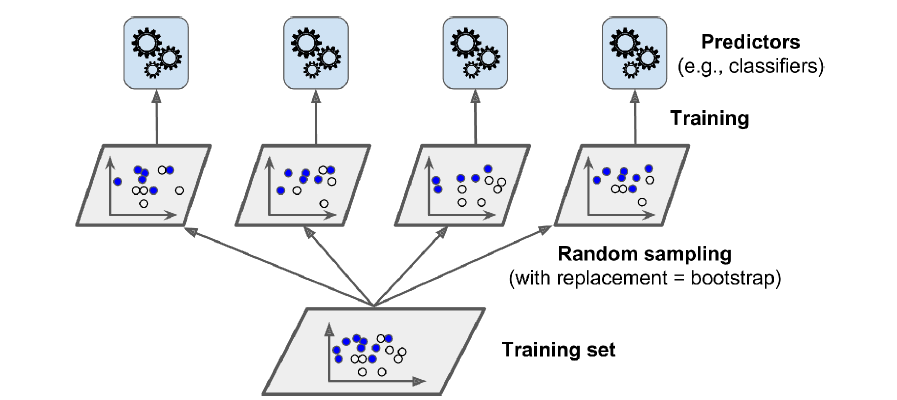|
|:---:|
|*Example of bagging to produce an ensemble of predictors*|

After training, the ensemble can make a prediction for a new instance by aggregating the predictions of all predictors: *statistical mode* (i.e., the most frequent prediction, just like a hard voting classifier) is common, or the average of the predictions for regression. Each individual predictor has a higher bias than if it were trained on the original training set, because they have been trained on smaller data sets. Aggregation reduces both bias *and* variance.

Since bagging and pasting rely on training several predictors at once, there is a natural inclination to use multiple CPU cores to train each concurrently. This means that these training methods scale really well.

### Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting in the `BaggingClassifier` class (or `BaggingRegressor` for regression).

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=seed)  
    # bootstrap=False will do pasting, n_jobs=-1 forces use of all cores
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.95


The `BaggingClassifier` automatically performs soft voting instead of hard boting if the base classifier can estimate class probabilities, which is the case with Decision Tree classifiers.

In [5]:
# next three blocks are code from Aurelion Geron just for making the following plots comparing a single tree and
# the bagging ensemble
tree_clf = DecisionTreeClassifier(random_state=seed)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.9


In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

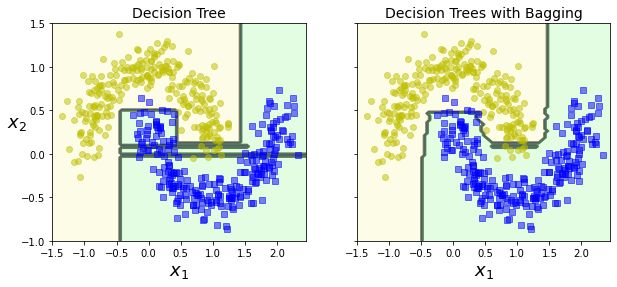

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Notice that the bias is roughly the same (the number of errors is roughly the same), but the variance is much smaller (the decision boundary is less irregular).

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on because the retrieved samples are replaced, making a bigger pool to pull data points from. Bagging thus ends up with a slightly higher bias than pasting. The extra diversity means that the predictors end up being less correlated though, so the ensemble's variance is reduced.

### Out-of-Bag Evaluation

Because the sampling in bagging is done *with replacement* there is a chance that instances will be sampled several times for any given predictor, while others may not be sampled at all. By default, a `BaggingClassifier` samples *m* training instances with replacement from a training set of size *m* (i.e. the bootstrapped sample has the same size as the original training set). This means that only about 63% of the training instances are sampled on average for each predictor (as *m* grows, the ratio approaches $1-e^{-1}\approx63.212\%$\*). The remaining 37% of the training instances that are not sampled are called *out-of-bag* (oob) instances.

\*See: [StackOverflow](https://stats.stackexchange.com/questions/15347/calculating-unsampled-in-sampling-with-replacement), [TowardDataScience](https://towardsdatascience.com/understanding-sampling-with-and-without-replacement-python-7aff8f47ebe4)

In [16]:
# data = pd.Series(np.arange(50000))
# bootstrap = data.sample(frac=1, replace=True, random_state=2)
# len(bootstrap.index.unique()) / len(data)
# prints 0.63276

A bagging ensemble can be evaluated using the oob instances without the need for a separate validation set: if there are enough estimators, then each instance in the training set will likely be an oob instance of several estimators, so these estimators can be used to make a fair ensemble prediction for that instance.

We can set `oob_score=True` when creating a `BaggingClassifier` to automatically request an oob evaluation after training:

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=seed, oob_score=True)  
    # bootstrap=False will do pasting, n_jobs=-1 forces use of all cores
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(bag_clf.__class__.__name__, 'oob score:', bag_clf.oob_score_)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier oob score: 0.9775
BaggingClassifier 0.95


### Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the features as well. Sampling is controlled by two hyperparameters: `max_features` and `bootstrap_features`. Thus, each predictor will be trained on a random subset of the input features.

This technique is useful with high-dimensional inputs (like images). Sampling both training instances and features is called the *Random Patches* method. Keeping all training instances (setting `bootstrap=False` and `max_samples=1.0`) but sampling features (`bootstrap_features=True` and `max_features` to a value smaller than 1.0) is called the *Random Subspaces* method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests